In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from LeNet import LeNet
from IPython.display import clear_output
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os
import seaborn as sn
import pandas as pd

In [2]:
def importImages(dir, label):
    paths = os.listdir(dir)
    x = []
    y = []
    
    for imagePath in paths:
        clear_output(wait=True)
        print(imagePath)

        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(dir + "/" + imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = imutils.resize(image, width=28)
        image = img_to_array(image)
        
        x.append(image)
        y.append(label)

    print("Total:", len(paths))
    return x, y

In [3]:
# scale the raw pixel intensities to the range [0, 1]
def convert(x, y):
    x = np.array(x, dtype="float") / 255.0
    y = np.array(y)
    return x, y

In [4]:
trainX, trainY = importImages("./datasets/train_folder/0", "not_smiling")

file3400.jpg
Total: 1238


In [5]:
x, y = importImages("./datasets/train_folder/1", "smiling");
trainX += x
trainY += y
trainX, trainY = convert(trainX, trainY)

file1562.jpg
Total: 1562


In [6]:
testX, testY = importImages("./datasets/test_folder/0", "not_smiling")

file4000.jpg
Total: 600


In [7]:
x, y = importImages("./datasets/test_folder/1", "smiling");
testX += x
testY += y
testX, testY = convert(testX, testY)

file2062.jpg


In [8]:
# convert the labels from integers to vectors
le = LabelEncoder().fit(trainY)
trainY = np_utils.to_categorical(le.transform(trainY), 2)
testY = np_utils.to_categorical(le.transform(testY), 2)

In [9]:
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals
classWeight = {i : classWeight[i] for i in range(len(classWeight))}
classWeight

In [10]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [11]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), class_weight=classWeight, batch_size=64, epochs=15, verbose=1)

[INFO] training network...
Epoch 1/15
44/44 [==============================] - 11s 212ms/step - loss: 0.7555 - accuracy: 0.5939 - val_loss: 0.6431 - val_accuracy: 0.6400
Epoch 2/15
44/44 [==============================] - 8s 190ms/step - loss: 0.6433 - accuracy: 0.7071 - val_loss: 0.5305 - val_accuracy: 0.7450
Epoch 3/15
44/44 [==============================] - 8s 183ms/step - loss: 0.5193 - accuracy: 0.7868 - val_loss: 0.5188 - val_accuracy: 0.7458
Epoch 4/15
44/44 [==============================] - 8s 180ms/step - loss: 0.4414 - accuracy: 0.8229 - val_loss: 0.3880 - val_accuracy: 0.8392
Epoch 5/15
44/44 [==============================] - 8s 176ms/step - loss: 0.3966 - accuracy: 0.8421 - val_loss: 0.3732 - val_accuracy: 0.8350
Epoch 6/15
44/44 [==============================] - 8s 181ms/step - loss: 0.3587 - accuracy: 0.8589 - val_loss: 0.3405 - val_accuracy: 0.8592
Epoch 7/15
44/44 [==============================] - 8s 179ms/step - loss: 0.3398 - accuracy: 0.8732 - val_loss: 0.3417 -

In [19]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, verbose=2)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))

[INFO] evaluating network...
38/38 - 1s - 786ms/epoch - 21ms/step
              precision    recall  f1-score   support

 not_smiling       0.85      0.87      0.86       600
     smiling       0.87      0.84      0.86       600

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200



<AxesSubplot:>

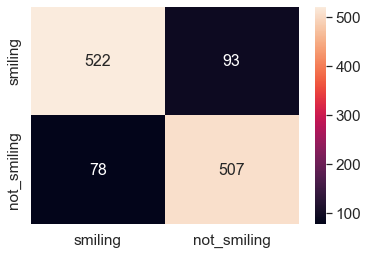

In [17]:
matrix = confusion_matrix(predictions.argmax(axis=1), testY.argmax(axis=1))
df_cm = pd.DataFrame(matrix, ["smiling", "not_smiling"], ["smiling", "not_smiling"])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="g") # font size

In [14]:
# save the model to disk
print("[INFO] serializing network...")
model.save("./model/LeNet")

[INFO] serializing network...
INFO:tensorflow:Assets written to: ./model/LeNet\assets


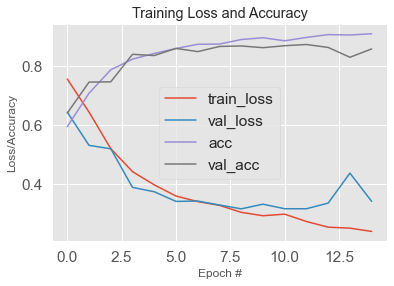

In [15]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()